<a href="https://colab.research.google.com/github/wilburshi/LogisticRegression_tutorial/blob/main/LogisticRegression_TrinaryChoice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression for Three-Option Juice Choice Task

Logistic regression can also be used to fit choice pattern with more than two options. This tutorial will analyze a trinary choice task.

Trinary Choice Task (Padoa-Schioppa, 2022)


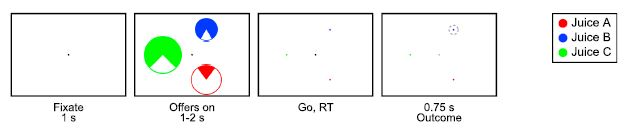

In [ ]:
from IPython.display import Image, display
print('Trinary Choice Task (Padoa-Schioppa, 2022)')
!git clone https://github.com/wilburshi/LogisticRegression_tutorial.git # use it only for google colab 
display(Image('LogisticRegression_tutorial/pics/TC_tasks.jpg', width=800, unconfined=True)) # use it only for google colab 
# display(Image('../pics/TC_tasks.jpg', width=800, unconfined=True))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as optim

## Simple regression

### Step 1: load data

First, let's load example data file named as `goodTrials_TC.mat`. It only contains trials that monkey has successfully chosen one of the juice option.  

`goodTrials_TC.mat` is a $N \times 9$, where $N$ is the number of the trials in this session, and in this example, $N = 600$. The columns of this matrix indicated:

 - *column 1*: the trial number.

 - *column 2*: the quantity of juice A.
 
 - *column 3*: the quantity of juice B. 
 
 - *column 4*: the quantity of juice C.
 
 - *column 5*: the probability of juice A.

 - *column 6*: the probability of juice B. 
 
 - *column 7*: the probability of juice C.
 
 - *column 8*: the chosen juice type, with 1 indicating A, 2 indicating B and 3 indicating C.

 - *column 9*: juice delivered, 0=no, 1=yes.

In [ ]:
# !git clone https://github.com/wilburshi/LogisticRegression_tutorial.git # use it only for google colab 
data = loadmat('LogisticRegression_tutorial/data/goodtrials_TC.mat')['goodTrials_TC'] # use it only for goole colab
# data = loadmat('../data/goodtrials_TC.mat')['goodTrials_TC'] # loadmat is a function in scipy.io used to load Matlab data file

# Independent variables
triNum = np.abs(data[:,0]) # trial number
QA = np.abs(data[:,1]) # quantity of juice A
QB = np.abs(data[:,2]) # quantity of juice B
QC = np.abs(data[:,3]) # quantity of juice C
PA = np.abs(data[:,4]) # probability of juice A
PB = np.abs(data[:,5]) # probability of juice B
PC = np.abs(data[:,6]) # probability of juice C

# Dependent variables
CJ = data[:,7] # the type of chosen juice. 1: chosen A, 2: chosen B, 3: chosen C

ind_forced = (data[:,1] == 0) | (data[:,2] == 0) | (data[:,3] == 0) # index of forced choice
ind_nonforced = ~ind_forced

### Step 2: logistic regression fitting
We use regression that is similar to logistic regression to fit the trinary choice pattern. The model is as follows:

$ P_A = 1/(1+exp(-(a_0-a_1+a_2log(p_A/p_B)+a_3log(q_A/q_B)))+exp(-(a_0+a_2log(p_A/p_C)+a_3log(q_A/q_C)))) $

$ P_B = 1/(1+exp(-(-a_0+a_1+a_2log(p_B/p_A)+a_3log(q_B/q_A)))+exp(-(a_1+a_2log(p_B/p_C)+a_3log(q_B/q_C)))) $

$ P_C = 1/(1+exp(-(-a_0+a_2log(p_C/p_A)+a_3log(q_C/q_A)))+exp(-(-a_1+a_2log(p_C/p_B)+a_3log(q_C/q_B)))) $

The maximum likelihood estimation is computed using the objective function
$ F =\prod_{i = 1,...,N}P^i_{chosen juice}$
where N is the number of trials and the probabilities $P^i_{chosen juice}$ are computed using equations above.


In [ ]:
# define customized regression function for trinary choice
def objectiveFun_logit3(betas):

    Y = CJ[ind_nonforced]
    iiA = Y == 1
    iiB = Y == 2
    iiC = Y == 3
    Q1 = np.log(QB[ind_nonforced]/QA[ind_nonforced])
    Q2 = np.log(QC[ind_nonforced]/QB[ind_nonforced])
    Q3 = np.log(QA[ind_nonforced]/QC[ind_nonforced])
    P1 = np.log(PB[ind_nonforced]/PA[ind_nonforced])
    P2 = np.log(PC[ind_nonforced]/PB[ind_nonforced])
    P3 = np.log(PA[ind_nonforced]/PC[ind_nonforced])
    
    FF = 0
    for ii in np.arange(0,np.shape(np.where(iiA))[1],1):  
        jj = np.where(iiA)[0][ii]
        FF = FF+np.log(1+np.exp(-betas[0]+betas[1]+betas[2]*P1[jj]+betas[3]*Q1[jj])+np.exp(-betas[0]-betas[2]*P3[jj]-betas[3]*Q3[jj]))
    for ii in np.arange(0,np.shape(np.where(iiB))[1],1):        
        jj = np.where(iiB)[0][ii]
        FF = FF+np.log(1+np.exp(betas[0]-betas[1]-betas[2]*P1[jj]-betas[3]*Q1[jj])+np.exp(-betas[1]+betas[2]*P2[jj]+betas[3]*Q2[jj]))
    for ii in np.arange(0,np.shape(np.where(iiC))[1],1):
        jj = np.where(iiC)[0][ii]
        FF = FF+np.log(1+np.exp(betas[0]+betas[2]*P3[jj]+betas[3]*Q3[jj])+np.exp(betas[1]-betas[2]*P2[jj]-betas[3]*Q2[jj]))
    return FF

In [ ]:
# find betas that is the maximum likelihood estimation
betas_init = [0,0,1,1]
betas = optim.fmin(func=objectiveFun_logit3, x0=betas_init)

Optimization terminated successfully.
         Current function value: 162.249173
         Iterations: 307
         Function evaluations: 520


In [ ]:
rhoA = np.exp(betas[0]/betas[3])
rhoB = np.exp(betas[1]/betas[3])
rhoC = np.array(1)
gamma = betas[2]/betas[3]
print('juice A relative value ρA is: ', np.array2string(rhoA))
print('juice A relative value ρB is: ', np.array2string(rhoB))
print('juice A relative value ρC is: ', np.array2string(rhoC))
print('steepness η is: ', np.array2string(eta))
print('risk attitude γ is: ', np.array2string(gamma))


juice A relative value ρA is:  3.62792938
juice A relative value ρB is:  2.6665506
juice A relative value ρC is:  1
steepness η is:  5.23870643
risk attitude γ is:  0.90832571


### Step 3: plotting
We plot the choice patterns using a simplex plot

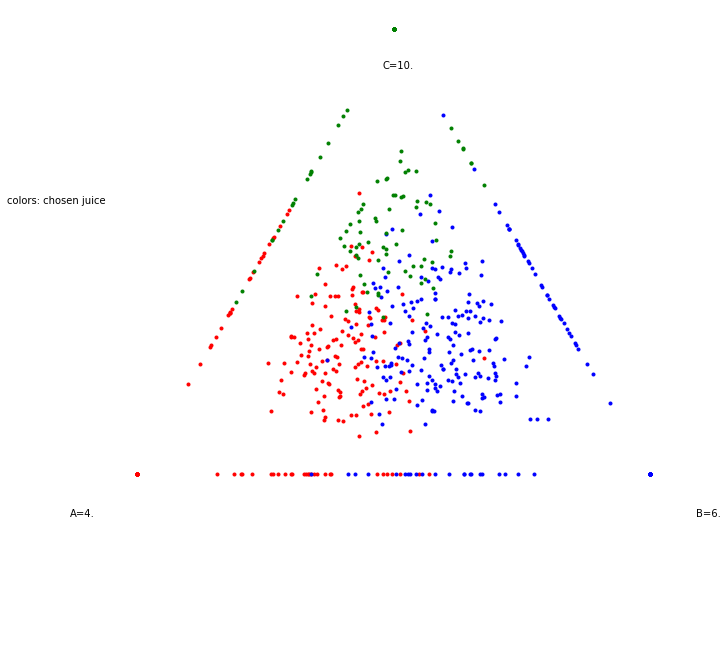

In [ ]:
EVA = QA*rhoA*(PA**gamma)
EVB = QB*rhoB*(PB**gamma)
EVC = QC*rhoC*(PC**gamma)
xx1 = EVA/np.max(EVA)
xx2 = EVB/np.max(EVB)
xx3 = EVC/np.max(EVC)
xy1 = ((2*xx2+xx3)/2)/(xx1+xx2+xx3)
xy2 = (np.sqrt(3)/2*xx3)/(xx1+xx2+xx3)

# plot data point using a simplex plot
fig= plt.figure(figsize=(12,9))
ii = CJ == 1
plt.plot(xy1[ii], xy2[ii], 'r.')
ii = CJ == 2
plt.plot(xy1[ii], xy2[ii], 'b.')
ii = CJ == 3
plt.plot(xy1[ii], xy2[ii], 'g.')
ax = plt.gca()
ax.set_aspect('equal')
ax.axis('off')
ax2 = fig.add_axes([-0.1,-0.1,1.2,np.sqrt(3)/2+0.1])
ax2.set_aspect('equal')
ax2.axis('off')
plt.text(-.1,.7,'colors: chosen juice')
plt.text( 0,0.2,'A='+np.array2string(np.max(QA)))
plt.text( 1,0.2,'B='+np.array2string(np.max(QB)))
plt.text(.5,np.sqrt(3)/2+.05,'C='+np.array2string(np.max(QC)));